In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

In [12]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_predict

# Load dataset
data_url = "https://raw.githubusercontent.com/elroedan/Predict_student_dropout/main/data.csv"
df = pd.read_csv(data_url, delimiter=';')

# Preprocess data
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Separate features and target
X = df.drop(columns=['Target'])  # Ensure 'Target' is correctly named
y = df['Target']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Base Models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Neural Network Model
def build_nn():
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

nn_model = build_nn()
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

# Train Base Models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Get predictions from base models
rf_pred = cross_val_predict(rf_model, X_train, y_train, cv=5, method="predict_proba")[:, 1]
xgb_pred = cross_val_predict(xgb_model, X_train, y_train, cv=5, method="predict_proba")[:, 1]
nn_pred = nn_model.predict(X_train).flatten()

# Stack predictions as input for meta-learner
stacked_features = np.column_stack((rf_pred, xgb_pred, nn_pred))
meta_model = LogisticRegression()
meta_model.fit(stacked_features, y_train)

# Get test set predictions
rf_test_pred = rf_model.predict_proba(X_test)[:, 1]
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]
nn_test_pred = nn_model.predict(X_test).flatten()
stacked_test_features = np.column_stack((rf_test_pred, xgb_test_pred, nn_test_pred))

# Final predictions using meta-learner
y_pred = meta_model.predict(stacked_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Stacked Model Test Accuracy: {accuracy:.4f}')


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.3392 - loss: -0.2035 - val_accuracy: 0.3644 - val_loss: -1.9111
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3683 - loss: -3.2631 - val_accuracy: 0.3701 - val_loss: -6.6745
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3827 - loss: -7.0256 - val_accuracy: 0.3757 - val_loss: -13.7819
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3833 - loss: -12.8177 - val_accuracy: 0.3771 - val_loss: -21.9759
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3789 - loss: -19.9936 - val_accuracy: 0.3757 - val_loss: -31.6734
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3791 - loss: -30.0042 - val_accuracy: 0.3757 - val_loss: -42.4942
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3767 - loss: -41.2544 - val_accuracy: 0.3771 - val_loss: -54.3502
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3592 - loss: -54.3595 - val_accuracy: 0.3

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone

# Load dataset
data_url = "https://raw.githubusercontent.com/elroedan/Predict_student_dropout/main/data.csv"
df = pd.read_csv(data_url, delimiter=';')

# Encode categorical features
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Separate features and target
X = df.drop(columns=['Target'])
y = df['Target'].values

# Multiclass target as one-hot
y_cat = to_categorical(y, num_classes=3)

# SMOTE only works with binary labels, so skip or use stratified split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train_cat, y_test_cat, y_train, y_test = train_test_split(
    X_scaled, y_cat, y, test_size=0.2, random_state=42, stratify=y)

# Neural Network Model
def build_nn():
    model = keras.Sequential([
        keras.layers.Dense(256, activation=keras.layers.LeakyReLU(), input_shape=(X_train.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation=keras.layers.LeakyReLU()),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize base models for multiclass
rf_model = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
xgb_model = XGBClassifier(objective='multi:softprob', num_class=3, n_estimators=150, learning_rate=0.05, max_depth=6, random_state=42)

# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

nn_model = build_nn()
nn_model.fit(X_train, y_train_cat, epochs=30, batch_size=32, validation_split=0.1,
             callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)], verbose=1)

# Predictions
rf_preds = rf_model.predict_proba(X_test)
xgb_preds = xgb_model.predict_proba(X_test)
nn_preds = nn_model.predict(X_test)

# Stack predictions for meta model
stacked_test = np.concatenate((rf_preds, xgb_preds, nn_preds), axis=1)

# Meta model: Gradient Boosting
meta_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05)
meta_model.fit(np.concatenate((rf_model.predict_proba(X_train), xgb_model.predict_proba(X_train), nn_model.predict(X_train)), axis=1), y_train)

final_preds = meta_model.predict(stacked_test)
accuracy = accuracy_score(y_test, final_preds)
print(f"🎯 Multiclass Stacked Model Accuracy: {accuracy:.4f}")


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5593 - loss: 1.2179 - val_accuracy: 0.7599 - val_loss: 0.6294
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7157 - loss: 0.7682 - val_accuracy: 0.7684 - val_loss: 0.5949
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7223 - loss: 0.7106 - val_accuracy: 0.7712 - val_loss: 0.6005
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7222 - loss: 0.7266 - val_accuracy: 0.7655 - val_loss: 0.5561
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7481 - loss: 0.6672 - val_accuracy: 0.7684 - val_loss: 0.5813
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7561 - loss: 0.6275 - val_accuracy: 0.7712 - val_loss: 0.5624
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7443 - loss: 0.6428 - val_accuracy: 0.7853 - val_loss: 0.5573
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7537 - loss: 0.6231 - val_accuracy: 0.7655 - val

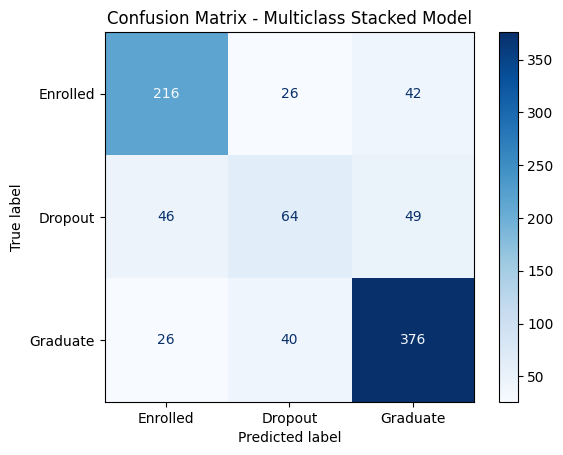

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Enrolled', 'Dropout', 'Graduate'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Multiclass Stacked Model')
plt.show()


In [6]:
from sklearn.metrics import classification_report

print(classification_report(y_test, final_preds, target_names=['Enrolled', 'Dropout', 'Graduate']))


              precision    recall  f1-score   support

    Enrolled       0.75      0.76      0.76       284
     Dropout       0.49      0.40      0.44       159
    Graduate       0.81      0.85      0.83       442

    accuracy                           0.74       885
   macro avg       0.68      0.67      0.68       885
weighted avg       0.73      0.74      0.74       885



<ipython-input-7-03d91a557a75>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=final_preds, palette='Set2')


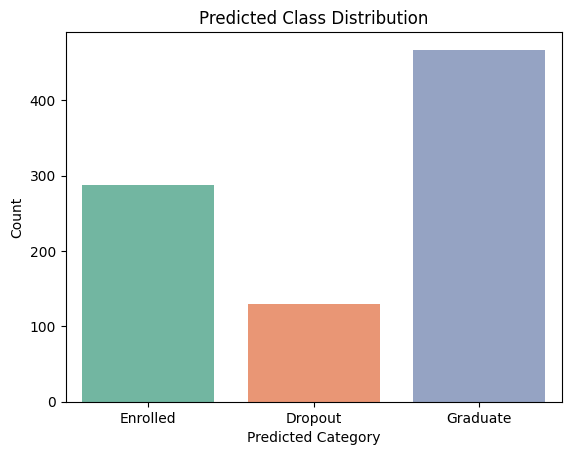

In [7]:
import seaborn as sns

sns.countplot(x=final_preds, palette='Set2')
plt.xticks(ticks=[0, 1, 2], labels=['Enrolled', 'Dropout', 'Graduate'])
plt.title('Predicted Class Distribution')
plt.xlabel('Predicted Category')
plt.ylabel('Count')
plt.show()


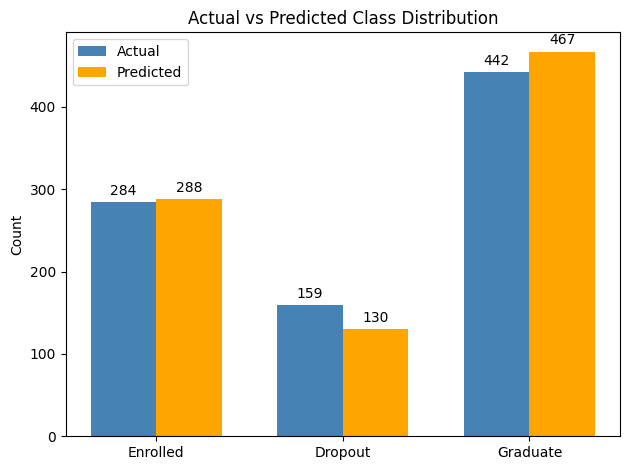

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Count occurrences
unique_classes = [0, 1, 2]
class_names = ['Enrolled', 'Dropout', 'Graduate']

actual_counts = [np.sum(y_test == cls) for cls in unique_classes]
pred_counts = [np.sum(final_preds == cls) for cls in unique_classes]

x = np.arange(len(class_names))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, actual_counts, width, label='Actual', color='steelblue')
rects2 = ax.bar(x + width/2, pred_counts, width, label='Predicted', color='orange')

# Labels, titles, etc
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Class Distribution')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Annotate bars
def annotate_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

annotate_bars(rects1)
annotate_bars(rects2)

plt.tight_layout()
plt.show()


<ipython-input-9-f2c3d903a7b2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df[:15], y=importance_df.index[:15], palette='coolwarm')


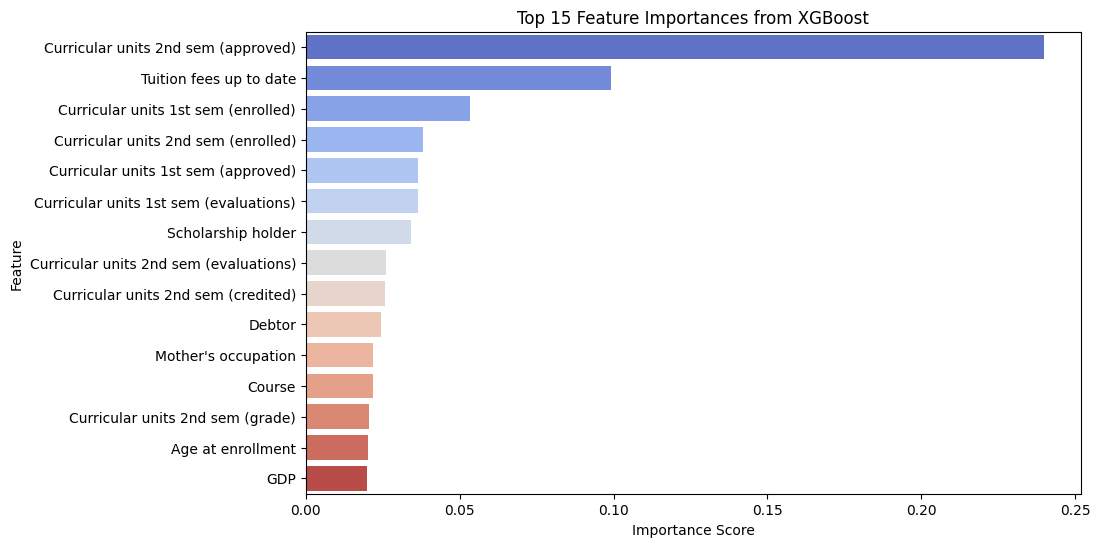

In [9]:
importances = xgb_model.feature_importances_
feat_names = X.columns
importance_df = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df[:15], y=importance_df.index[:15], palette='coolwarm')
plt.title('Top 15 Feature Importances from XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
